
# ARSENL Backscatter Experiments

Grant Kirchhoff
05-31-2022
University of Colorado Boulder

Fit the photon arrival time tags to Gaussian profiles from ARSENL INPHAMIS lidar. 

IMPORTANT: Set data path settings in
'load_ARSENL_data.py' first.

In [1]:
import numpy as np
import pandas as pd
import time
import pickle
import matplotlib.pyplot as plt
import torch

from load_ARSENL_data import load_INPHAMIS_data, data_dir, fname, picklename
from elapsed_time import get_t_elap

In [90]:
### CONSTANTS ####
c = 299792458              # [m/s] Speed of light
max_rollover = 2**25 * 25  # [ps] the maximum timestamp before instrument timer rolls over

### PARAMETERS ###
create_csv = 0             # Set true to generate a .csv from .ARSENL data
load_data = False          # Set true to load data into a DataFrame and serialize into a pickle object
irregular_data = True      # Set true if data has gaps (i.e., dtime is 0 for many clock cycles)
exclude_bnd = [0, 60000]   # Set boundaries for binning


In [91]:
# Load INPHAMIS .ARSENL data if not yet serialized
if load_data:
    load_INPHAMIS_data(data_dir, fname, picklename, create_csv)

# Unpickle the data to DataFrame object
infile = open('{}/{}'.format(data_dir, picklename), 'rb')
df_orig = pickle.load(infile)
infile.close()

In [92]:
# Extract detection and sync events

df_clean = df_orig.loc[df_orig['dtime'] != 0]         # Ignore data gaps

df_clean = df_clean[0:10000]

rollover = df_clean.loc[(df_clean['overflow'] == 1) & \
                        (df_clean['channel'] == 63)]  # Rollover event ("overflow","channel") = (1,63)
detect = df_clean.loc[(df_clean['overflow'] == 0) & \
                      (df_clean['channel'] == 0)]     # Detection events ("overflow","channel") = (0,0)
sync = df_clean.loc[(df_clean['overflow'] == 1) & \
                    (df_clean['channel'] == 0)]       # Sync events ("overflow","channel") = (1,0)

sync_detect_idx = df_orig.index.searchsorted(detect.index, side='left') - 1  # Return index of sync pulse that caused detection event
sync_detect = df_orig.loc[sync_detect_idx]

# If data has gaps then ignore detection events that happen to occur immediately after a data gap
if irregular_data:
    sync_detect = sync_detect.loc[sync_detect['dtime'] != 0]
    detect = df_clean.loc[sync_detect.index + 1]

In [93]:
print("sync: {}".format(len(sync.index)))
print("detect: {}".format(len(detect.index)))
print("rollover: {}".format(len(rollover.index)))

sync: 5940
detect: 3550
rollover: 501


In [94]:
rollover_num = len(rollover)
final_tstamp = sync.iloc[-1]['dtime'] * 25
t_elap = get_t_elap(max_rollover, rollover_num, final_tstamp)  # [ps] total time elapsed
t_elap /= 1e12  # [s] 

In [95]:
# Convert sync/detection events to flight times

detect_time = detect['dtime'].to_numpy()
sync_detect_time = sync_detect['dtime'].to_numpy()

flight_time = (detect_time - sync_detect_time) * 25  # [ps] Time is in segments of 25 ps
flight_time = flight_time[np.where((flight_time >= exclude_bnd[0]) & (flight_time < exclude_bnd[1]))]  # Exclude t.o.f. where bins ~= 0

# Try:
# flight_time = flight_time[np.where((flight_time ))]

distance = flight_time / 1e12 * c / 2

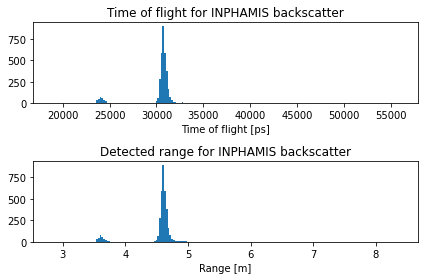

In [96]:
# Time-of-flight histogram

fig = plt.figure()
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
n1, bins1, patches1 = ax1.hist(flight_time, bins=200)
n2, bins2, patches2 = ax2.hist(distance, bins=200)
ax1.set_xlabel('Time of flight [ps]')
ax1.set_title('Time of flight for INPHAMIS backscatter')
ax2.set_xlabel('Range [m]')
ax2.set_title('Detected range for INPHAMIS backscatter')
plt.tight_layout()
plt.show()

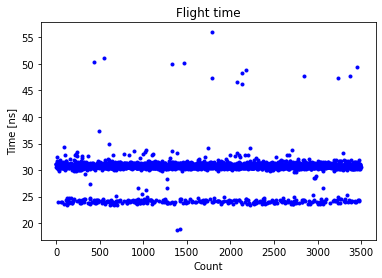

In [97]:
plt.plot(flight_time/1000, 'b.')
plt.title('Flight time')
plt.xlabel('Count')
plt.ylabel('Time [ns]')
plt.show()

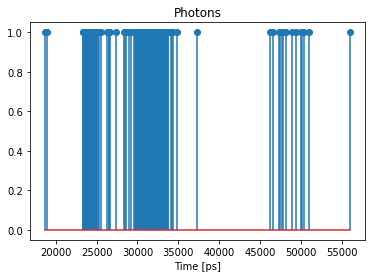

In [98]:
plt.figure()
plt.stem(flight_time, np.ones(flight_time.size))
plt.title('Photons')
plt.xlabel('Time [ps]')
plt.show()

#### Now transitioning to applying the curve_fit routine to my data. Code pulled from Matt Hayman's "Fit_TimeTag_Gaussian.ipynb"

In [171]:
# build the fit model as a NN module
class Fit_Pulse(torch.nn.Module):
    def __init__(self,t_max):
        """
        Instantiate and initialize the fit parameters.
        """
        super().__init__()
        self.log_A = torch.nn.Parameter(6.45*torch.ones(()))   # Gaussian amplitude
        self.log_mu = torch.nn.Parameter(-17.5*torch.ones(()))  # Gaussian mean
        self.log_sig = torch.nn.Parameter(-22*torch.ones(())) # Gaussian std
        self.log_b = torch.nn.Parameter(1*torch.ones(()))      # background
        
        self.log_AA = torch.nn.Parameter(6.4*torch.ones(()))   # Gaussian amplitude
        self.log_mumu = torch.nn.Parameter(-17*torch.ones(()))  # Gaussian mean
        self.log_sigsig = torch.nn.Parameter(-20*torch.ones(())) # Gaussian std
        
        self.t_max = t_max # maximum time evaluated in integral term
        
        self.sqrt_2pi = torch.sqrt(torch.tensor(2*np.pi))
        self.sqrt_2  = torch.sqrt(torch.tensor(2.0))
        

    def forward(self, t):
        """
        Forward model the profile for input time t.
        Also return the integral.
        """
        # calculate all the actual fit parameters
        A = torch.exp(self.log_A)
        mu = torch.exp(self.log_mu)
        sig = torch.exp(self.log_sig)
        b = torch.exp(self.log_b)
        
        AA = torch.exp(self.log_AA)
        mumu = torch.exp(self.log_mumu)
        sigsig = torch.exp(self.log_sigsig)
        
        # calculate the forward model
        model_out = A*torch.exp(-1*(t-mu)**2/(2*sig**2)) + b + AA*torch.exp(-1*(t-mumu)**2/(2*sigsig**2))
        
        # calculate the integral
        integral_out = b*self.t_max \
                        + 0.5*A*sig*self.sqrt_2pi \
                        + 0.5*A*sig*self.sqrt_2pi\
                            *torch.special.erf((self.t_max-mu)/(sig*self.sqrt_2))
            
        return model_out, integral_out

In [172]:
def pois_loss(prof,integral):
    """
    Poisson point process loss function
    prof: estimated photon arrival rate evaluated at
        each time tag
    integral: integral of prof at t_max
    """
    return integral-torch.sum(torch.log(prof))

In [183]:
# optimization parameters
# rel_step_lim = 1e-15  # termination criteria based on step size
# max_epochs = 5000     # maximum number of iterations/epochs
# learning_rate = 1e-1  # ADAM learning rate
# term_persist = 20     # relative step size averaging interval in iterations

rel_step_lim = 1e-15  # termination criteria based on step size
max_epochs = 50000     # maximum number of iterations/epochs
learning_rate = 1e-4  # ADAM learning rate
term_persist = 20     # relative step size averaging interval in iterations

In data set, the frequency of the sync pulses is ~14.2kHz. Therefore, t_max ~= 70.2043 usec. Might need to look into having this dynamically adjusted.

In [184]:
t_max = 70.2043e-6  # [s]

# Time vector between each laser pulse (sync event)
t_inst_min = 0
t_inst_max = t_max
dt_inst = 25 * 1e-12  # [s]
t_inst = np.arange(t_inst_min, t_inst_max, dt_inst)

In [185]:
# initialize for fit loop
fit_model = Fit_Pulse(t_max)
optimizer = torch.optim.Adam(fit_model.parameters(), lr=learning_rate)
epoch = 0
rel_step = 1e3*rel_step_lim
train_loss_lst = []
rel_step_lst = []

init_log_A = fit_model.log_A.item()
init_log_mu = fit_model.log_mu.item()
init_log_sig = fit_model.log_sig.item()
init_log_b = fit_model.log_b.item()

init_log_AA = fit_model.log_AA.item()
init_log_mumu = fit_model.log_mumu.item()
init_log_sigsig = fit_model.log_sigsig.item()

In [186]:
# set the loss function to use a 
# Poisson point process likelihood function
loss_fn = pois_loss

In [187]:
t_phot_fit = flight_time * 1e-12  # [s] convert to seconds
t_phot_fit_tnsr = torch.tensor(t_phot_fit)
cnt_phot_fit = len(sync.index)

In [188]:
# perform fit
while rel_step > rel_step_lim and epoch < max_epochs:
    
    fit_model.train()
    pred, integral = fit_model(t_phot_fit_tnsr)
    loss = loss_fn(pred, integral*cnt_phot_fit)  # add regularization here
    train_loss_lst += [loss.item()]

    # calculate relative step as an average over the last
    # term_persist iterations
    if epoch == 0:
        rel_step_lst+=[1e3*rel_step_lim]
        rel_step = 1e3*rel_step_lim
    else:
        rel_step_lst+=[(train_loss_lst[-2]-train_loss_lst[-1])/np.abs(train_loss_lst[-2])]
        rel_step = np.abs(np.array(rel_step_lst)[-term_persist:].mean())

    # update estimated parameters
    loss.backward()
    optimizer.step()
    
    # zero out the gradient for the next step
    optimizer.zero_grad()
    
    epoch+=1
    

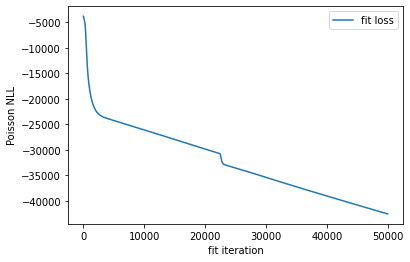

In [189]:
# plot the loss over iterations
plt.figure()
plt.plot(train_loss_lst,label='fit loss')
plt.xlabel('fit iteration')
plt.ylabel('Poisson NLL')
plt.legend()

In [190]:
pred_mod_full, integral_full = fit_model(torch.tensor(t_inst))

In [191]:
print('Initial A: {}'.format(np.exp(init_log_A)))
print('Initial mu: {}'.format(np.exp(init_log_mu)))
print('Initial sig: {}'.format(np.exp(init_log_sig)))
print('Initial b: {}\n'.format(np.exp(init_log_b)))

print('A: {}'.format(torch.exp(fit_model.log_A)))
print('mu: {}'.format(torch.exp(fit_model.log_mu)))
print('sig: {}'.format(torch.exp(fit_model.log_sig)))
print('b: {}\n'.format(torch.exp(fit_model.log_b)))

print('AA: {}'.format(torch.exp(fit_model.log_AA)))
print('mumu: {}'.format(torch.exp(fit_model.log_mumu)))
print('sigsig: {}'.format(torch.exp(fit_model.log_sigsig)))

Initial A: 632.7021721338796
Initial mu: 2.510999155743982e-08
Initial sig: 2.7894680928689246e-10
Initial b: 2.718281828459045

A: 104569.546875
mu: 3.0310506105024615e-08
sig: 1.75965961801694e-08
b: 0.7286725044250488

AA: 91614.03125
mumu: 3.032120332591148e-08
sigsig: 9.822665703040911e-08


In [192]:
torch.mean(t_phot_fit_tnsr)

tensor(3.0316e-08, dtype=torch.float64)

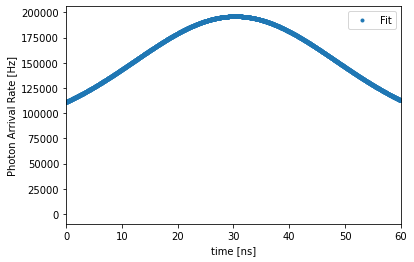

In [193]:
plt.figure()
# n1, bins1, patches1 = plt.hist(flight_time, bins=200, label='Actual hist')
plt.plot(t_inst*1e9,pred_mod_full.detach().numpy(),'.',label='Fit') # /cnt_phot_fit
plt.xlim([0, 60])
plt.xlabel('time [ns]')
plt.ylabel('Photon Arrival Rate [Hz]')
plt.legend()

# fig = plt.figure()
# ax1 = fig.add_subplot(211)
# ax2 = fig.add_subplot(212)
# n1, bins1, patches1 = ax1.hist(flight_time, bins=200)
# n2, bins2, patches2 = ax2.hist(distance, bins=200)
# ax1.set_xlabel('Time of flight [ps]')
# ax1.set_title('Time of flight for INPHAMIS backscatter')
# ax2.set_xlabel('Range [m]')
# ax2.set_title('Detected range for INPHAMIS backscatter')
# plt.tight_layout()
# plt.show()